In [13]:
import torch
from torch.utils.data import Dataset
import numpy as np
from statistics import mean
import os

In [14]:
#Get a bounding box from a mask.
def get_bounding_box(ground_truth_map):

  # define edges of the mask location
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - 10 - np.random.randint(0, 10))
  x_max = min(W, x_max + 10 + np.random.randint(0, 10))
  y_min = max(0, y_min - 10 - np.random.randint(0, 10))
  y_max = min(H, y_max + 10 + np.random.randint(0, 10))

  x_center = mean([x_min, x_max])
  y_center = mean([y_min, y_max])
  box_width = x_max - x_min
  box_height = y_max - y_min

  # create a normalized label:
  bbox = [x_center/W, y_center/H, box_width/W, box_height/H]

  return bbox

In [15]:
loaded_dict = np.load('data/8_lms/downsampled_metadata.npy', allow_pickle=True).item()
training = loaded_dict['training']
testing = loaded_dict['testing']

In [16]:
import os

if not os.path.isdir('datasets/yolo_8/train/images'):
    os.makedirs('datasets/yolo_8/train/images')
if not os.path.isdir('datasets/yolo_8/val/images'):
    os.makedirs('datasets/yolo_8/val/images')

if not os.path.isdir('datasets/yolo_8/train/labels'):
    os.makedirs('datasets/yolo_8/train/labels')
if not os.path.isdir('datasets/yolo_8/val/labels'):
    os.makedirs('datasets/yolo_8/val/labels')

In [17]:
root_image_folder = 'data/root_image_folder'
training[0].keys()

dict_keys(['id', 'labels', 'label_names', 'has_annotation', 'original image size', 'image resolutions', 'image'])

In [18]:
landmark_labels =["A01_r","A02_r","F23_r","F24_r",
                  "A01_l","A02_l","F23_l","F24_l"]
classes_dict = {}
for i, lm in enumerate(landmark_labels):
    classes_dict[lm] = i

In [19]:
def label_to_class(classes_dict, name):
    return classes_dict[name]

In [20]:
from PIL import Image

def image_np2jpg(ind_id, input_folder, output_folder):
    img_array = np.load(os.path.join(input_folder, f'{ind_id}.npz'))
    origImage =  img_array[img_array.files[0]]
    origImage = origImage*255/max(origImage.flatten())
    image = Image.fromarray(np.uint8(origImage)).convert('RGB')
    image.save(os.path.join(output_folder, f'{ind_id}.jpg'))
    return image 

In [21]:
len(training[0]['label_names'][0])

8

In [22]:
# create training
training_images_array = []
train_images_output = 'datasets/yolo_8/train/images'

for ind in training:
    ind_id = ind["id"]
    ind_label_names = ind['label_names'][0]
    image_np2jpg(ind_id, root_image_folder, train_images_output)
    training_images_array.append(f'{ind_id}.jpg')
    with open(os.path.join('datasets/yolo_8/train/labels', f'{ind_id}.txt'), 'w') as file:
        for i, label in enumerate(ind['labels'][0]):
            bbox = get_bounding_box(label)
            label_name = ind_label_names[i]
            file.write(f'{label_to_class(classes_dict, label_name)} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

In [23]:
# create validation from testing
val_images_array = []
val_images_output = 'datasets/yolo_8/val/images'
for ind in testing:
    ind_id = ind["id"]
    ind_label_names = ind['label_names'][0]
    image_np2jpg(ind_id, root_image_folder, val_images_output)
    training_images_array.append(f'{ind_id}.jpg')
    with open(os.path.join('datasets/yolo_8/val/labels', f'{ind_id}.txt'), 'w') as file:
        for i, label in enumerate(ind['labels'][0]):
            bbox = get_bounding_box(label)
            label_name = ind_label_names[i]
            file.write(f'{label_to_class(classes_dict, label_name)} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def parse_label(path_to_file):
    list_of_boxes = []
    with open(path_to_file) as f:
      for line in f:
         items = line.split()
         label = items[0]
         x_center = float(items[1])
         y_center = float(items[2])
         W = float(items[3])
         H = float(items[4])
         x0 = x_center - 0.5*W
         y0 = y_center - 0.5*H
         list_of_boxes.append([label, x0*1024, y0*1024, W*1024, H*1024])
    return list_of_boxes

def show_boxes(boxes_array, ax):
    for box in boxes_array:
        ax.add_patch(plt.Rectangle((box[1], box[2]), box[3], box[4], edgecolor='green', facecolor=(0,0,0,0), lw=2))
        ax.text(box[1], box[2], box[0], ha='center')  

# def masked_label(label_array): 
#     masked_data = np.ma.masked_where(label_array < 1, label_array)
#     plt.imshow(masked_data, cmap=cm.autumn)

def show_boxes_on_image(raw_image, boxes, label_array):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    # masked_label(label_array)
    show_boxes(boxes, plt.gca())
    plt.axis('on')
    plt.show()

In [25]:
im = Image.open('datasets/yolo_8/train/images/001.jpg')
boxes = parse_label('datasets/yolo_8/train/labels/001.txt')

print(training[0]['id'])
label_array = np.sum(training[0]['labels'], axis = 0)
label_array.shape

001


(8, 1024, 1024)

In [26]:
show_boxes_on_image(im, boxes, label_array)

<Figure size 1000x1000 with 1 Axes>

In [27]:
landmark_labels =["A01_r","A02_r","F23_r","F24_r",
                  "A01_l","A02_l","F23_l","F24_l"]
reverse_classes_dict = {}
for i, lm in enumerate(landmark_labels):
    reverse_classes_dict[i] = lm

In [28]:
import yaml
yam = {}
yam['path'] = 'yolo_8'
yam['train'] = 'train/images'
yam['val'] = 'val/images'
yam['names'] = reverse_classes_dict
with open('yolo_set.yaml', 'w') as yaml_file:
    yaml.dump(yam, yaml_file, default_flow_style=False)

In [29]:
# load pretrained model
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

In [30]:
results = model.train(data="yolo_set.yaml", epochs=300, imgsz=640, degrees=10, hsv_v=0.3, fliplr=0.0, flipud=0.0, device=0, exist_ok=True)

New https://pypi.org/project/ultralytics/8.3.72 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=yolo_set.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False

train: Scanning /home/katya/Huggingface/datasets/yolo_8/train/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 588.95it/s]

train: New cache created: /home/katya/Huggingface/datasets/yolo_8/train/labels.cache



val: Scanning /home/katya/Huggingface/datasets/yolo_8/val/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 354.55it/s]

val: New cache created: /home/katya/Huggingface/datasets/yolo_8/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.46G      5.172      6.419      3.113         29        640: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         19        152          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.43G      4.647       6.36      2.811          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         19        152          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.43G      3.741      5.504        1.9         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         19        152          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.46G      3.182      5.124      1.606          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         19        152          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.45G      2.995      4.971      1.431          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

                   all         19        152          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.46G      2.815      4.698      1.363          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


                   all         19        152   0.000164    0.00658   0.000482   4.82e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.45G      2.649      4.444      1.319          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         19        152   0.000308     0.0132   0.000791   0.000126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.45G      2.973      4.158      1.345         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         19        152    0.00091     0.0461     0.0305     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.47G      2.761      3.872      1.346          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         19        152    0.00211      0.105     0.0529     0.0164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.44G       2.52      3.641      1.332          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         19        152    0.00561      0.197     0.0961     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.44G      2.463      3.312      1.267         10        640: 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         19        152     0.0128      0.237     0.0444    0.00994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.45G      2.591      3.208      1.264         11        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         19        152     0.0256       0.48      0.177     0.0515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.43G      2.311        4.7      1.287          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         19        152     0.0358      0.592       0.24     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.46G       2.59      2.896       1.37          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         19        152     0.0139      0.178     0.0228    0.00444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.44G      2.463      2.889      1.262          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         19        152     0.0264      0.322     0.0663     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.44G      2.418      2.459      1.245          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         19        152      0.391       0.16      0.211     0.0684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.44G      2.362      2.415       1.22          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


                   all         19        152      0.398      0.047       0.15      0.037

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.47G      2.415      2.435      1.276          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         19        152      0.565      0.321       0.34     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.46G      2.297      2.246      1.184         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


                   all         19        152      0.547      0.268      0.286     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.44G      2.263      2.151       1.19         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         19        152      0.582      0.345      0.396       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.45G      2.354      2.091      1.189         31        640: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         19        152      0.555      0.344      0.448      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.43G      2.234      2.013      1.175         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         19        152       0.72      0.343      0.533      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.46G        2.2      1.987      1.156         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all         19        152      0.747       0.39       0.59      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.46G      2.148      1.913      1.137         20        640: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         19        152      0.693      0.491      0.602      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.46G      2.145      1.854      1.183          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         19        152      0.493      0.468      0.507      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.47G      2.135      1.835      1.144         16        640: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         19        152      0.582      0.494      0.575      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.44G      2.065      1.714       1.16          8        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         19        152      0.606      0.533      0.586      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.43G      2.263      2.072      1.283          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         19        152      0.629      0.565      0.637      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.47G      2.066      1.728       1.16          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         19        152      0.658      0.567      0.658      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.45G      2.192      1.702      1.181         31        640: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         19        152      0.687      0.702      0.732       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.46G      2.232      1.625      1.139         29        640: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         19        152      0.637      0.656      0.718       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.45G      2.077      1.629      1.164          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         19        152       0.65      0.686      0.728      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.44G      2.019      1.658      1.161          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         19        152      0.714       0.72      0.739      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.45G      2.076       1.57      1.153         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         19        152        0.7      0.751      0.759      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.47G      1.859      1.475      1.095         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19        152       0.78      0.738      0.787      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.45G       2.06      1.552      1.195          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         19        152      0.618       0.71      0.717      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.46G      1.859      1.444        1.1          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         19        152      0.781      0.575      0.696      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.44G      2.006      1.523      1.111         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         19        152      0.669       0.75      0.727      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.43G      1.948      1.405      1.081         23        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         19        152      0.753      0.793      0.777      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.44G       1.89      1.363      1.084          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all         19        152      0.743      0.726      0.755      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.46G      2.156       1.45      1.125         14        640: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


                   all         19        152      0.753      0.769       0.76       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.45G      2.016      1.362      1.099         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


                   all         19        152      0.691      0.746      0.734       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.46G      1.876      1.398      1.093          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         19        152      0.645      0.696      0.663      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.45G      1.833      1.456      1.116          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


                   all         19        152      0.713      0.758      0.737      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.47G      1.945       1.37      1.069         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         19        152      0.708      0.781      0.755      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.45G      1.938      1.378      1.105          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         19        152      0.686       0.76      0.744      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.44G      1.892      1.367      1.066          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all         19        152      0.704      0.669      0.733      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.44G      1.995      1.483      1.217          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all         19        152       0.75      0.684      0.755      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.46G      1.863      1.257      1.076         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         19        152      0.707      0.763      0.761      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.45G       1.82      1.322      1.078          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         19        152      0.698      0.729      0.758      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.46G      2.021       1.35      1.217          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         19        152      0.699      0.795      0.773        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.42G      1.847       1.26      1.084         19        640: 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         19        152      0.778      0.771      0.792      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.44G      1.754      1.233       1.04         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


                   all         19        152      0.775      0.801      0.794      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.44G      1.759       1.22      1.068          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         19        152      0.701      0.769       0.76      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.43G      1.774      1.214      1.082          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         19        152      0.719      0.741      0.733      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.44G      1.825      1.226      1.048          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         19        152      0.713      0.719      0.735      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.42G      1.805      1.202      1.081          8        640: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         19        152      0.749       0.75      0.748      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.48G      1.894       1.32      1.099          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         19        152      0.707      0.753      0.741      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.45G      1.697      1.247      1.076          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         19        152      0.745      0.775      0.777       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.44G      1.909       1.28      1.082         30        640: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         19        152       0.68      0.701      0.709      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.46G      1.802       1.84      1.111          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         19        152      0.781      0.795      0.805      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.44G      1.741      1.175      1.053          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         19        152      0.773      0.795       0.81      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.45G      1.785      1.162      1.046          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         19        152      0.729      0.791      0.792      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.44G      1.734       1.24      1.064          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         19        152      0.727      0.814      0.804      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.46G      1.773      1.237      1.032         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         19        152      0.714       0.81      0.796      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.45G       1.62      1.117      1.019          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         19        152      0.751      0.775      0.786      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.44G      1.697      1.169      1.028          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         19        152      0.725      0.801      0.797      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.44G      1.685      1.107      1.012          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         19        152      0.764      0.814      0.806      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.44G      1.721      1.176      1.038          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         19        152      0.775      0.839      0.823      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.45G      1.677      1.282      1.086          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         19        152      0.776      0.788      0.791       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.44G      1.663      1.165      1.069          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         19        152      0.776       0.78      0.802      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.46G      1.707      1.157      1.006         28        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


                   all         19        152      0.785      0.807      0.817      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.45G      1.633      1.106      1.023          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         19        152      0.784      0.739      0.765      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.45G      1.668      1.175      1.006         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         19        152      0.778      0.755      0.797      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.46G      1.638      1.136      1.023          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         19        152      0.763      0.804      0.807      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.43G      1.605      1.069      1.028          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         19        152      0.753      0.797      0.796      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.45G      1.659      1.065      1.019         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         19        152      0.789      0.779      0.812      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.44G      1.545       1.03      1.011          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         19        152      0.756      0.774      0.791      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.43G      1.716      1.124      1.018         26        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         19        152      0.733      0.784      0.777      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.45G      1.786      1.124      1.019         30        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all         19        152      0.702      0.734      0.742      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.47G      1.815      1.111      1.039         21        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         19        152      0.749      0.747      0.779      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.44G      1.968      1.256      1.166          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all         19        152      0.758      0.709      0.726       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.44G      1.812      1.205      1.095          6        640: 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         19        152      0.726      0.693      0.725      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.44G      1.672      1.109      1.037          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         19        152      0.737      0.722      0.759      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.44G      1.635      1.034      1.036          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         19        152      0.787      0.762      0.784      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.44G      1.768      1.156      1.051          5        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         19        152      0.753      0.821      0.786      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.46G      1.829      1.113      1.045         22        640: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


                   all         19        152       0.74      0.796      0.767      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.44G      1.696      1.124      1.026          9        640: 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         19        152      0.744      0.756       0.75      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.46G      1.672      1.192      1.064          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         19        152      0.751      0.752      0.748      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.45G      1.638      1.102      1.002         20        640: 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         19        152      0.798      0.808      0.817      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.44G      1.607      1.096      1.015          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         19        152       0.76      0.786      0.771       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.43G      1.644      1.057      1.077          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         19        152      0.754      0.749      0.754      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.46G      1.495     0.9853     0.9947          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         19        152      0.734      0.783      0.771      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.44G      1.611      1.133     0.9991          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         19        152      0.763      0.797      0.797      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.43G      1.596      1.059     0.9786         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         19        152       0.76      0.793      0.773      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.47G      1.567      1.001      0.984         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


                   all         19        152      0.748      0.815      0.786       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.43G      1.557     0.9967      1.005         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         19        152      0.777      0.811      0.804       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.45G      1.601      1.008     0.9763         10        640: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         19        152      0.807      0.797      0.807      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.45G      1.659      1.104      1.034         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all         19        152      0.759      0.794       0.79      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.45G      1.543     0.9908     0.9676         24        640: 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         19        152      0.818      0.833       0.83      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.45G      1.576      1.004     0.9954         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         19        152      0.805      0.822      0.822      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.45G      1.524     0.9809     0.9689         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         19        152      0.802      0.812      0.826      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.45G      1.599      1.027     0.9758         23        640: 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


                   all         19        152      0.799      0.825      0.844      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.44G      1.268      2.054     0.8028          0        640: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         19        152      0.812      0.846      0.834      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.44G      1.564      1.011          1          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         19        152      0.805      0.822      0.818      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.45G      1.649      1.003      1.082          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         19        152      0.805      0.824      0.829      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.45G      1.569     0.9465     0.9929          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         19        152      0.833      0.842      0.831      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.44G      1.546     0.9869      1.005         21        640: 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         19        152      0.784      0.795      0.805      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.45G      1.571     0.9533     0.9632         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         19        152      0.776      0.785        0.8      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.45G       1.23      1.806     0.8074          0        640: 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         19        152      0.777      0.812      0.785      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.44G      1.491     0.9717      1.013          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         19        152      0.809       0.83      0.807      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.46G      1.505     0.9282     0.9703         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         19        152      0.819      0.843      0.817      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.45G      1.485     0.9244       0.98         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         19        152      0.798      0.814      0.803      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.45G      1.559     0.9399     0.9647         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         19        152       0.76      0.794       0.79      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.45G      1.542     0.9825     0.9711         24        640: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         19        152      0.768        0.8      0.799      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.45G       1.51     0.9622     0.9762         28        640: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         19        152      0.796      0.803      0.808      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.45G      1.457     0.9299     0.9732         14        640: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         19        152      0.787      0.832      0.807      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.43G      1.382     0.8661     0.9329         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         19        152      0.786      0.808      0.786      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.44G      1.545     0.9918      1.034          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


                   all         19        152      0.839      0.839       0.83      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.44G      1.487     0.9646     0.9835          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         19        152      0.779      0.806      0.771      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.47G      1.483     0.9202     0.9881          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         19        152      0.779      0.789      0.768        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.45G      1.477     0.8974     0.9915          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         19        152      0.776      0.761      0.776      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.44G      1.503      0.929     0.9802          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         19        152      0.789      0.776      0.785      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.39G      1.542     0.9841     0.9626         31        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         19        152      0.789      0.787      0.776      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.46G      1.429     0.8771     0.9321         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


                   all         19        152      0.776      0.765       0.78      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.44G      1.549      1.036      1.037          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         19        152      0.788      0.814      0.827      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.45G      1.431     0.9081     0.9789          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         19        152      0.803      0.826      0.837      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.44G      1.574     0.9298      1.077          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         19        152      0.786       0.76      0.782      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.44G      1.496     0.9355      1.034          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         19        152      0.776      0.762       0.77      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.44G      1.421     0.8528     0.9272          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         19        152      0.777      0.792      0.773       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.43G      1.384     0.8541      0.962          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         19        152      0.729      0.785      0.748      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.39G      1.451     0.8667     0.9601          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         19        152      0.798      0.793      0.783      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.44G      1.404      0.848     0.9538          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         19        152      0.781      0.762      0.778      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.46G      1.338     0.8437     0.9423         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         19        152      0.766      0.761      0.753      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.47G      1.512      1.019     0.9716          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         19        152       0.76      0.761      0.746      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.46G      1.474     0.8806      0.977         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         19        152       0.76       0.78      0.746      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.47G      1.438     0.8937     0.9496         19        640: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         19        152      0.774        0.8      0.767      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.44G       1.46     0.8885     0.9571          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         19        152      0.764      0.759      0.754       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.47G      1.624     0.9651      1.045          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         19        152      0.781      0.777      0.765      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.47G      1.473     0.8689     0.9713         13        640: 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         19        152      0.769      0.807      0.782      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.43G      1.373     0.8255     0.9334          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         19        152      0.744        0.8      0.766      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300       2.4G      1.396     0.8611     0.9579          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         19        152       0.75      0.787      0.786       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.47G      1.534     0.9279      1.012          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         19        152      0.785      0.758      0.788      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.43G      1.513     0.8929     0.9581         30        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         19        152      0.749      0.817      0.789      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.46G      1.518     0.9037     0.9465         28        640: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         19        152      0.731      0.803       0.77      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.46G       1.41     0.8806     0.9917          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         19        152      0.756      0.812      0.772      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300       2.4G      1.319     0.8131     0.9418         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         19        152      0.755      0.813      0.783      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.47G      1.431     0.8491     0.9261         19        640: 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all         19        152      0.768      0.817      0.799      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.47G      1.308     0.7825     0.9333         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         19        152      0.812      0.826      0.808      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.43G      1.383     0.8311     0.9995          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         19        152      0.821      0.817      0.797      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.44G      1.544      1.114      1.005          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         19        152      0.805      0.799      0.777      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.44G      1.364     0.8418     0.9385          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         19        152      0.805      0.819       0.81      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.45G       1.42     0.8711     0.9938          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         19        152      0.806      0.819      0.794      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.45G      1.422     0.8244     0.9348         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all         19        152      0.786      0.807       0.79      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.45G      1.356     0.8026     0.9215         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         19        152      0.803      0.817      0.804       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.45G      1.376     0.8043      0.928         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19        152       0.83       0.83       0.83      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.44G       1.46     0.8262      0.946         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         19        152      0.818      0.811      0.807        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.46G      1.318      0.827     0.9214         21        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         19        152      0.805      0.792      0.795      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.44G      1.537       1.49      1.001          3        640: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         19        152      0.768      0.808      0.794      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.44G      1.406     0.8334     0.9242         23        640: 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         19        152      0.778      0.772      0.785      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.43G      1.318     0.8411     0.9789          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         19        152      0.781      0.798      0.803      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.46G      1.351     0.7952     0.9411          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         19        152      0.782      0.824      0.803        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.47G       1.36     0.7904     0.9125         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         19        152      0.797      0.774       0.78      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.44G      1.404     0.8809      1.017          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         19        152      0.828      0.806      0.814      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.43G      1.262      0.772     0.9173          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         19        152      0.805      0.817       0.81      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.46G      1.412      0.785     0.9947          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         19        152      0.785      0.818       0.81      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.44G      1.289     0.7879     0.9189          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


                   all         19        152      0.787      0.818      0.816      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.42G      1.077      1.579     0.7914          0        640: 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         19        152      0.785      0.824      0.795      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.44G      1.384      0.826     0.9229         23        640: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         19        152      0.788      0.838      0.807      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.44G      1.311     0.7773     0.9282          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


                   all         19        152      0.805      0.789      0.795       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.43G      1.274     0.7533     0.9355          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


                   all         19        152       0.77      0.828      0.795      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.45G      1.464      0.844      1.066          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


                   all         19        152      0.797      0.821      0.806      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.45G      1.427     0.8414     0.9435         32        640: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         19        152      0.788      0.806      0.796      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.39G      1.348     0.8306      0.979          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         19        152      0.763      0.788      0.778      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.43G      1.336     0.8213     0.9815          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         19        152      0.775       0.85      0.813      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.44G      1.299     0.7879     0.9443         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         19        152      0.828      0.783      0.804      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.43G      1.336     0.8066     0.9516          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         19        152      0.774      0.819      0.788      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.42G      1.328     0.7888     0.9786          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         19        152      0.771      0.794       0.76      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.44G      1.308     0.7851     0.9216         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


                   all         19        152      0.756      0.796      0.752        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.44G       1.24     0.7514     0.9177          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         19        152      0.772      0.802      0.763      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.45G      1.314     0.8049      0.981          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         19        152      0.759      0.797      0.757      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.47G      1.334     0.9884     0.9431          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         19        152      0.766      0.805      0.783      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.45G      1.276     0.7896     0.9206         23        640: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         19        152      0.756      0.814       0.78      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.47G       1.37     0.8772     0.9636          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         19        152      0.778      0.794      0.781      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.44G      1.438     0.8368      1.046          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         19        152      0.773      0.773      0.767      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.45G      1.289     0.7746     0.9075         26        640: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         19        152      0.806      0.766      0.771      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.45G      1.447     0.8161     0.9427         17        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         19        152      0.799      0.798       0.77      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.43G      1.462     0.8342      1.061          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         19        152       0.78      0.763      0.763      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.44G      1.296     0.7785      0.939         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


                   all         19        152      0.738      0.796      0.751      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.45G      1.301     0.8947     0.9356          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all         19        152      0.785      0.792      0.766      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.44G      1.276     0.7592     0.9244          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


                   all         19        152      0.785      0.783      0.764      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.44G      1.317     0.7662      0.975          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         19        152      0.773      0.794      0.764      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.45G      1.288      0.759     0.9082         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         19        152      0.776      0.767      0.757      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.39G      1.308     0.7665     0.9118         16        640: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         19        152      0.814      0.779      0.784      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.44G      1.276     0.7505     0.9533          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         19        152      0.808      0.775      0.769      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.43G      1.561      1.097     0.9942          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all         19        152      0.776      0.787       0.77      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.42G       1.38     0.7983     0.9305         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         19        152      0.799      0.795      0.779      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.45G      1.327     0.7687     0.9272         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         19        152      0.761      0.784      0.754      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.45G      1.269     0.7394     0.9093         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         19        152      0.757      0.763      0.748      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.45G      1.322     0.7616     0.9165         23        640: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         19        152      0.804      0.757      0.788      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.43G      1.257     0.7159     0.9052         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         19        152       0.79        0.8      0.791      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.43G      1.218     0.7439     0.9269         11        640: 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         19        152      0.749      0.802      0.762      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.45G      1.308     0.7372     0.9211          8        640: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         19        152      0.779      0.782      0.754       0.29


EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 103, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

203 epochs completed in 0.128 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


                   all         19        152      0.799      0.825      0.842      0.326
                 A01_r         19         19      0.687      0.737      0.796      0.262
                 A02_r         19         19      0.795      0.817      0.809      0.296
                 F23_r         19         19      0.951          1      0.995       0.41
                 F24_r         19         19       0.82      0.895      0.863      0.372
                 A01_l         19         19      0.812       0.68      0.759       0.29
                 A02_l         19         19      0.872      0.895      0.881      0.384
                 F23_l         19         19      0.856      0.947      0.962      0.342
                 F24_l         19         19      0.601      0.632      0.671      0.252
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


In [36]:
# predict
images = os.listdir('datasets/yolo_8/val/images')
# # load pretrained model
from ultralytics import YOLO
model = YOLO("runs_8_lms_300/detect/train/weights/best.pt") 


In [ ]:
model.val()

In [6]:
all_results = {}
for image in images:
    result = model(f'datasets/yolo_8/val/images/{image}', project='runs_8_lm_300')
    name = image[:-4]
    all_results[name] = result[0]

image 1/1 /home/katya/Huggingface/datasets/yolo_8/val/images/094.jpg: 640x640 1 A01_r, 1 A02_r, 1 F23_r, 2 F24_rs, 1 A02_l, 1 F23_l, 1 F24_l, 77.2ms
Speed: 6.0ms preprocess, 77.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/katya/Huggingface/datasets/yolo_8/val/images/083.jpg: 640x640 1 A01_r, 1 A02_r, 1 F23_r, 3 F24_rs, 1 A01_l, 1 A02_l, 1 F23_l, 2 F24_ls, 66.8ms
Speed: 5.3ms preprocess, 66.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/katya/Huggingface/datasets/yolo_8/val/images/089.jpg: 640x640 1 A01_r, 1 A02_r, 1 F23_r, 1 F24_r, 2 A01_ls, 1 A02_l, 1 F23_l, 4 F24_ls, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/katya/Huggingface/datasets/yolo_8/val/images/082.jpg: 640x640 1 A01_r, 1 A02_r, 1 F23_r, 1 F24_r, 1 A01_l, 1 A02_l, 1 F23_l, 1 F24_l, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3,

In [7]:
import yaml

with open('yolo_set.yaml') as file:
    yaml_file = yaml.safe_load(file)
label_code = yaml_file['names']
def convert_code2label(code, label_code=label_code):
    return next((val for key, val in label_code.items() if key == code), None)

In [8]:
len(label_code)

8

In [9]:
import pandas as pd

def collect_class_accuracy(individ_summary):
    df = pd.DataFrame(individ_summary)
    df = df.set_index('name')
    classes = [int(x) for x in df['class'].to_list()]
    res = {}
    for c in range(len(label_code)):
        if c in classes:
            res[c] = df.loc[df['class']==c, 'confidence'].to_numpy()[0]
        else: res[c] = 0
    return res

stats = []
for key, result in all_results.items():
    summary = result.summary()
    class_accuracies = collect_class_accuracy(summary)
    class_accuracies['mean'] = (sum([float(x) for x in list(class_accuracies.values())]))/len(class_accuracies.keys())
    class_accuracies['name'] = key   
    stats.append(class_accuracies)

df = pd.DataFrame(stats)
df = df.set_index('name')

In [10]:
colnames = [convert_code2label(col) for col in df.columns]
df.columns = colnames
df

,A01_r,A02_r,F23_r,F24_r,A01_l,A02_l,F23_l,F24_l,None
name,,,,,,,,,
094,0.66646,0.54523,0.90004,0.55937,0.00000,0.29341,0.63015,0.63201,0.528334
083,0.92089,0.80528,0.55199,0.68655,0.63432,0.78053,0.86035,0.52270,0.720326
089,0.91840,0.76472,0.69422,0.54161,0.52750,0.63511,0.68778,0.79404,0.695422
082,0.73679,0.79503,0.90340,0.75719,0.62081,0.77603,0.79066,0.76143,0.767667
100,0.79593,0.68820,0.82649,0.67233,0.50476,0.80336,0.71023,0.66598,0.708410
084,0.87830,0.73138,0.75622,0.75650,0.43019,0.74459,0.79799,0.73650,0.728959
093,0.64605,0.79571,0.83310,0.62551,0.36056,0.80182,0.78355,0.79657,0.705359
087,0.85981,0.90414,0.77421,0.76524,0.39070,0.74146,0.86307,0.74529,0.755490
095,0.68200,0.59655,0.80235,0.82689,0.35033,0.58605,0.50283,0.63880,0.623225


In [11]:
df.to_csv('runs_8_lms_300/detect/val/testing_accuracy.csv')

In [12]:
for col in df.columns:
    print(col, df[col].mean())

A01_r 0.7407242105263158
A02_r 0.6784973684210526
F23_r 0.8207442105263157
F24_r 0.6975642105263159
A01_l 0.43299105263157894
A02_l 0.6921105263157895
F23_l 0.7624368421052632
F24_l 0.7099568421052632
None 0.6918781578947368



image 1/1 /home/katya/Huggingface/datasets/yolo_8/val/images/082.jpg: 640x640 1 A01_r, 1 A02_r, 1 F23_r, 1 F24_r, 1 A01_l, 1 A02_l, 1 F23_l, 1 F24_l, 82.8ms
Speed: 7.4ms preprocess, 82.8ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)


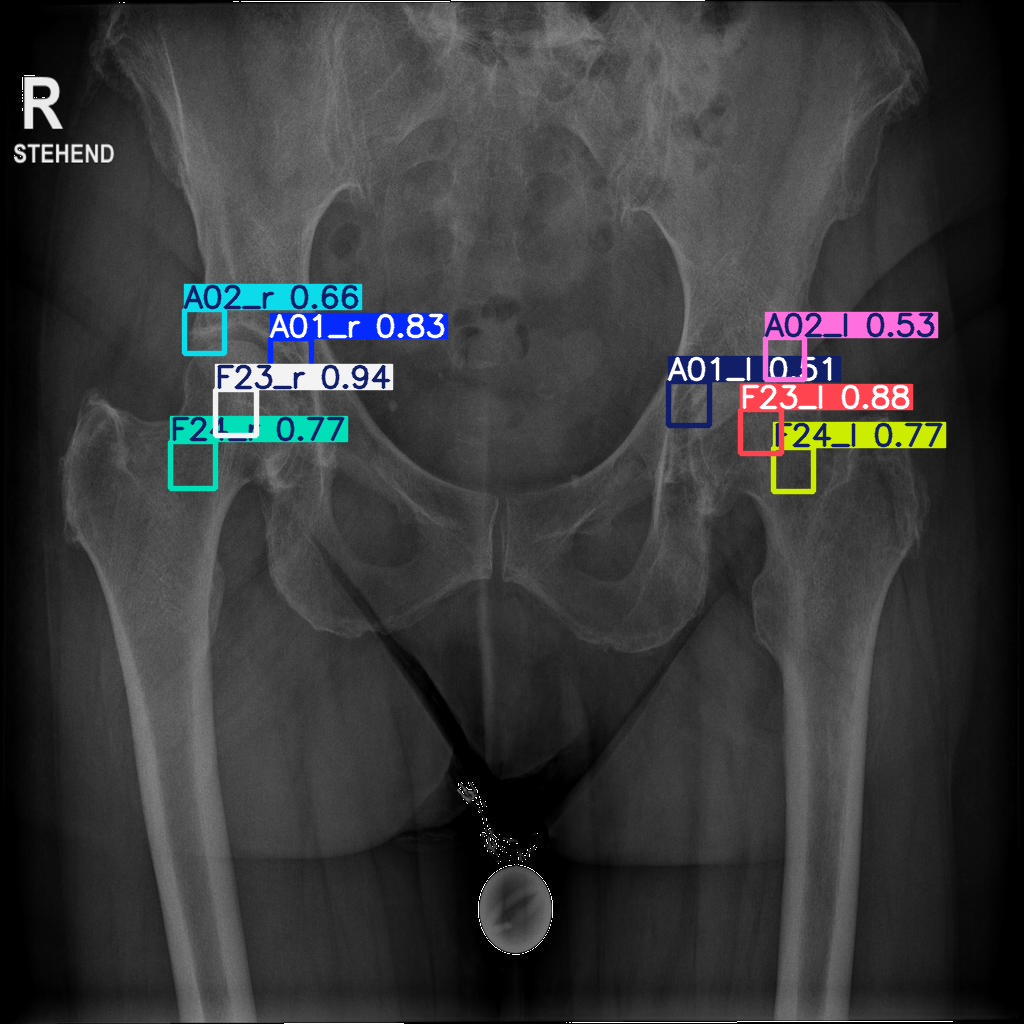

In [38]:
#test = images[1]
res = model(f'datasets/yolo_8/val/images/082.jpg', project='runs_8_lm_300', name = 'test_one')
res[0].show()